In [1]:
# Pick up package from parent folder
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(
    inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import sklearn
from sklearn import metrics
from sklearn.datasets import load_boston, load_diabetes
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.utils.multiclass import unique_labels
import statsmodels.api as sm
import time

import ordinal
from ordinal import OrderedProbitRanker
from ordinal import OrderedLogitRanker

In [3]:
def fitscore(model, X, y):
    start = time.time()
    model.fit(X, y)
    pred_val = model.predict(X)
    pred_proba = model.predict_proba(X)
    print("time: ", time.time() - start)
    print("score: ", metrics.accuracy_score(y, pred_val))
    print("mse: ", metrics.mean_squared_error(y, pred_val))
    print("mae: ", metrics.mean_absolute_error(y, pred_val))
    pd.Series(pred_val).hist(bins=N_CLASSES)

# Boston prepro

In [4]:
N_CLASSES = 15

boston = load_boston()
X = boston['data']
y = boston['target']
kbd = KBinsDiscretizer(n_bins=N_CLASSES, 
                       encode='ordinal',
                       strategy='uniform')
y = kbd.fit_transform(y.reshape(-1, 1)).flatten().astype(np.int32)

In [5]:
pd.Series(y).hist(bins=N_CLASSES)

time:  5.472894668579102
score:  0.5019762845849802
mse:  2.207509881422925
mae:  0.8241106719367589


C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


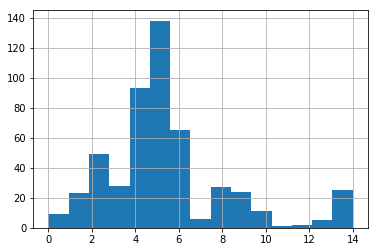

In [6]:
lr = LogisticRegression(C=1., solver='lbfgs', multi_class='auto', max_iter=40000)
fitscore(lr, X, y)

time:  11.291469812393188
score:  0.4209486166007905
mse:  1.8675889328063242
mae:  0.8399209486166008


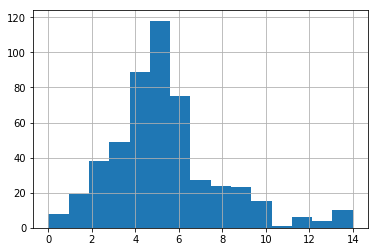

In [7]:
lat = OrderedLogitRanker(alpha=1, verbose=1, variant='at')
fitscore(lat, X, y)

time:  9.581343412399292
score:  0.3675889328063241
mse:  1.901185770750988
mae:  0.9288537549407114


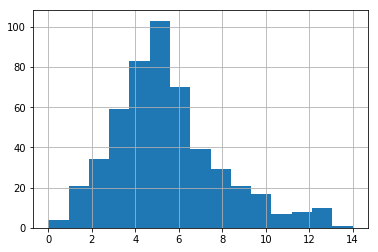

In [8]:
lse = OrderedLogitRanker(alpha=1, verbose=1, variant='se')
fitscore(lse, X, y)

time:  12.780541181564331
score:  0.4367588932806324
mse:  4.0395256916996045
mae:  1.1462450592885376


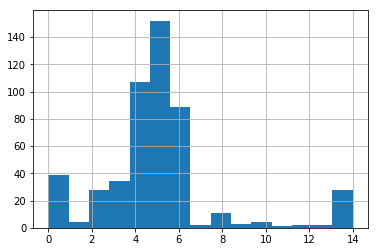

In [23]:
opr = OrderedProbitRanker(method='L-BFGS-B', use_grad=False)
fitscore(opr, X, y)

# Testing

In [27]:
opr = OrderedProbitRanker(method='L-BFGS-B', use_grad=False)
start = time.time()
opr.fit(X, y)
pred_val = opr.predict(X)
print("time: ", time.time() - start)
print("score: ", metrics.accuracy_score(pred_val, y))
print("cuts: ", opr.cuts_)

time:  12.423946619033813
score:  0.4367588932806324
cuts:  [ -80.70313703   44.91470935  633.37260676 1280.76644843 2279.96987958
 3488.39474865 4200.32278279 4301.62599891 4462.92628156 4525.73620318
 4587.00848836 4626.62414908 4662.41427679 4690.22862278]


In [25]:
ymasks = np.array([np.array(y == c_) for c_ in opr.classes_])

n_class = len(opr.classes_)
n_cuts = len(opr.classes_) - 1
n_samples = X.shape[0]
n_features = X.shape[1]


n_cuts = ymasks.shape[0] - 1
xb = X @ opr.coef_
# bottom and top cutpoints are -inf and inf
# cumsum ensures cutpoints remain ordered
cuts = np.hstack((-np.inf, opr.cuts_, np.inf))
# Get the distribution's area between each cutpoint
# expr x[:,None] - xb outputs shape (n_class - 1, n_samples)
cdf_areas = norm.cdf(cuts[:, None] - xb)
dist_areas = np.diff(cdf_areas, axis=0)
res = np.sum(ymasks * dist_areas, axis=0)

In [20]:
pd.DataFrame(dist_areas.T)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.0,0.000000,0.000000e+00,0.0,0.000000e+00,1.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.000000e+00,0.0,0.000000e+00,1.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,1.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,3.923698e-195,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,1.0,5.988099e-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,1.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.000000,0.000000e+00,0.0,0.000000e+00,1.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.000000,0.000000e+00,0.0,1.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.000000,3.781647e-35,1.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.000000,0.000000e+00,0.0,1.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
np.log(res)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


array([           -inf,  0.00000000e+00,            -inf,            -inf,
                  -inf,            -inf,  0.00000000e+00,            -inf,
        0.00000000e+00,  0.00000000e+00,            -inf,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,            -inf,            -inf,
                  -inf, -9.37871899e-08,  0.00000000e+00,            -inf,
                  -inf,  0.00000000e+00,            -inf,            -inf,
                  -inf,            -inf,            -inf,            -inf,
                  -inf,  0.00000000e+00,            -inf,            -inf,
                  -inf,            -inf,            -inf,            -inf,
        0.00000000e+00,  0.00000000e+00,            -inf, -2.26016564e-06,
                  -inf, -3.84953039e+02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,            -inf,  0.00000000e+00,            -inf,
        0.00000000e+00,  0.00000000e+00,            -inf,  0.00000000e+00,
        0.00000000e+00,  